In [4]:
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from deeplab import DeepLabV3Plus

import os

from tfrecord_iterator import parse_tfrecords
from tfrecord_creator import create_tfrecords
from utils import get_miniade20k

print('TensorFlow', tf.__version__)

TensorFlow 2.2.0


In [5]:
images_path, xml_path, num_classes, dataset_size = get_miniade20k()

batch_size = 2
H, W = 512, 512

tfrecord_dir = os.path.join(os.getcwd(), 'tfrecords')
os.makedirs(tfrecord_dir, exist_ok=True)

checkpoint_dir = os.path.join(os.getcwd(), 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

create_tfrecords(images_path, xml_path, tfrecord_dir)

88571904/88566414 [==============================] - 7s 0us/step


  3%|▎         | 14/500 [00:00<00:03, 136.12it/s]

Writing :: train-00001-of-00004.tfrecord


  3%|▎         | 17/500 [00:00<00:02, 166.93it/s]

Writing :: train-00002-of-00004.tfrecord


  4%|▍         | 21/500 [00:00<00:02, 194.29it/s]

Writing :: train-00003-of-00004.tfrecord


  4%|▍         | 19/497 [00:00<00:02, 186.16it/s]

Writing :: train-00004-of-00004.tfrecord


100%|██████████| 497/497 [00:02<00:00, 172.00it/s]

Num unique labels :: 151


In [8]:
tf.keras.backend.clear_session()

In [9]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model = DeepLabV3Plus(H, W, num_classes)
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.momentum = 0.9997
        layer.epsilon = 1e-5
    elif isinstance(layer, tf.keras.layers.Conv2D):
        layer.kernel_regularizer = tf.keras.regularizers.l2(1e-4)
model.compile(loss=loss, 
              optimizer=tf.optimizers.Adam(learning_rate=1e-4), 
              metrics=['accuracy'])




*** Building DeepLabv3Plus Network ***
*** Output_Shape => (None, 512, 512, 152) ***


In [12]:
tb = TensorBoard(log_dir='logs', write_graph=True, update_freq='batch')
mc = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'top_weights_{epoch:02d}.h5'),
                     #monitor='val_loss',
                     #save_best_only='True',
                     #save_weights_only='True',
                     period=10, 
                     verbose=1)
callbacks = [mc]#, tb]

In [13]:
train_tfrecords = os.path.join(tfrecord_dir, 'train*.tfrecord')
input_function = parse_tfrecords(
    filenames=train_tfrecords,
    height=H,
    width=W,
    batch_size=batch_size)

model.fit(input_function,
          steps_per_epoch=dataset_size//batch_size,
          epochs=100,
          #validation_data=input_function,
          #validation_steps=dataset_size//batch_size,
          callbacks=callbacks)

Epoch 1/100
1000/1000 [==============================] - 127s 127ms/step - loss: 1.9124 - accuracy: 0.5638
Epoch 2/100
1000/1000 [==============================] - 131s 131ms/step - loss: 1.6919 - accuracy: 0.6048
Epoch 3/100
1000/1000 [==============================] - 132s 132ms/step - loss: 1.5424 - accuracy: 0.6308
Epoch 4/100
1000/1000 [==============================] - 131s 131ms/step - loss: 1.4481 - accuracy: 0.6499
Epoch 5/100
1000/1000 [==============================] - 130s 130ms/step - loss: 1.3415 - accuracy: 0.6681
Epoch 6/100
1000/1000 [==============================] - 130s 130ms/step - loss: 1.2734 - accuracy: 0.6828
Epoch 7/100
1000/1000 [==============================] - 130s 130ms/step - loss: 1.1811 - accuracy: 0.6988
Epoch 8/100
1000/1000 [==============================] - 130s 130ms/step - loss: 1.1129 - accuracy: 0.7144
Epoch 9/100
1000/1000 [==============================] - 130s 130ms/step - loss: 1.0704 - accuracy: 0.7208
Epoch 10/100
1000/1000 [=============

1000/1000 [==============================] - 128s 128ms/step - loss: 0.1118 - accuracy: 0.9624
Epoch 69/100
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0982 - accuracy: 0.9662
Epoch 70/100
1000/1000 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9582
Epoch 00070: saving model to /mnt/mydata/checkpoints/top_weights_70.h5
1000/1000 [==============================] - 128s 128ms/step - loss: 0.1251 - accuracy: 0.9582
Epoch 71/100
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0975 - accuracy: 0.9664
Epoch 72/100
1000/1000 [==============================] - 128s 128ms/step - loss: 0.1292 - accuracy: 0.9575
Epoch 73/100
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0871 - accuracy: 0.9694
Epoch 74/100
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0863 - accuracy: 0.9696
Epoch 75/100
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0822 - accuracy

In [19]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [42]:
img = cv2.imread('./mini_ADE20K/images/ADE_val_00000029.jpg')
image = tf.cast(img, tf.uint8)
image = tf.image.resize(image,(H, W))
image = tf.cast(image, tf.keras.backend.floatx())
#image.set_shape([H,W,3])
normalized_image = image-[103.939, 116.779, 123.68]
normalized_image = np.expand_dims(normalized_image, axis=0)
#normalized_image = normalized_image.reshape((1, H, W, 3))
y = model.predict(normalized_image)
#y.shape

In [43]:
final = np.argmax(y, axis=-1)[0]
print(final.shape, final.max(), final.min(), np.unique(final))

(512, 512) 145 0 [  0   1   2   4   6   9  11  13  14  15  16  19  25  28  31  32  33  36
  38  39  41  42  43  45  48  51  56  59  60  63  68  75 123 145]


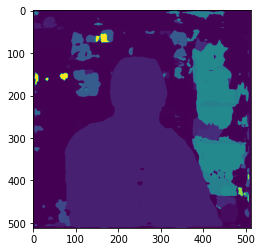

In [44]:
plt.imshow(final)

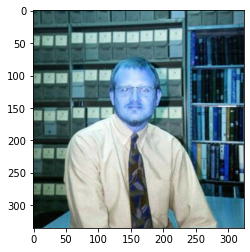

In [41]:
plt.imshow(img)